# Advanced Keras Tutorial 2

This notebook contains 

1) transfer learning. 

2) Multi-GPU and distributed training


In [1]:
import os
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [4]:
keras.__version__, tf.__version__

('2.0.8', '1.3.0')

## Transfer Learning using Keras
### What is Transfer Learning?
Transfer learning, is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem.
## Why Transfer Learning?
- In practice a very few people train a Convolution network from scratch (random initialisation) because it is rare to get enough dataset. So, using pre-trained network weights as initialisations or a fixed feature extractor helps in solving most of the problems in hand.

- Very Deep Networks are expensive to train. The most complex models take weeks to train using hundreds of machines equipped with expensive GPUs.

- Determining the topology/flavour/training method/hyper parameters for deep learning is a black art with not much theory to guide you.

- Some Computer Vision Problems don’t have very large datasets(5000 images — 40,000 images). Even with extreme data augmentation strategies it is difficult to achieve decent accuracy. Training these networks with millions of parameters generally tend to overfit the model. So Transfer learning comes to our rescue.

## How Transfer Learning helps ?
When you look at what these Deep Learning networks learn, they try to detect edges in the earlier layers, Shapes in the middle layer and some high level data specific features in the later layers. These trained networks are generally helpful in solving other computer vision problems. Lets have a look at how to do transfer learning using Keras and various cases in Transfer learning.
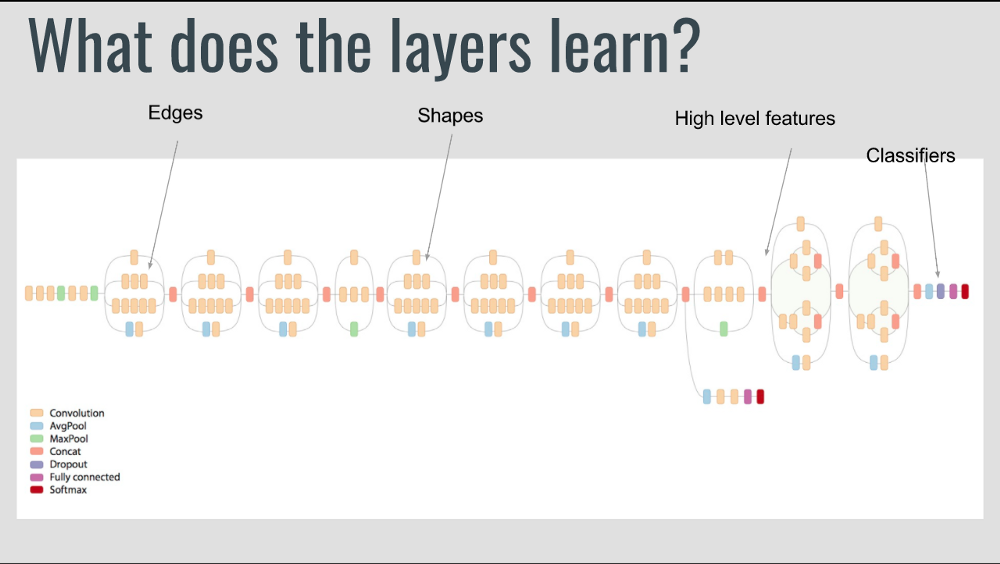

Lets take a look at input.

In [23]:
from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

input
keras_advanced_2.ipynb
mnist_advanced.ipynb
mnist_quick_start.ipynb
README.md



Use data augementation to generate more data on fly. 

In [21]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(rotation_range=40, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             shear_range=0.2, 
                             zoom_range=0.2, 
                             horizontal_flip=True, 
                             fill_mode='neareast')
img = load_img('input/train/cats/cat.0.jpg') 
x = img_to_array(img) #This is a Numpy array with shape(3, 150, 150)
x = x.reshape((1,)+x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

#the .flow() command below generates batches of randomly transformed images
#and saves the results to the 'preview/' directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='preview',
                         save_prefix='cat',
                         save_format='jpeg')
    i += 1
    if i > 20:
        break 
#display images

Lets train a  baseline model.

In [24]:
# https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K


# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('first_try.h5')

OSError: [Errno 2] No such file or directory: 'data/train'

## Fine-tuning the top layers of a a pre-trained network
To further improve our previous result, we can try to "fine-tune" the last convolutional block of the VGG16 model alongside the top-level classifier. Fine-tuning consist in starting from a trained network, then re-training it on a new dataset using very small weight updates. In our case, this can be done in 3 steps:

- instantiate the convolutional base of VGG16 and load its weights
- add our previously defined fully-connected model on top, and load its weights
- freeze the layers of the VGG16 model up to the last convolutional block
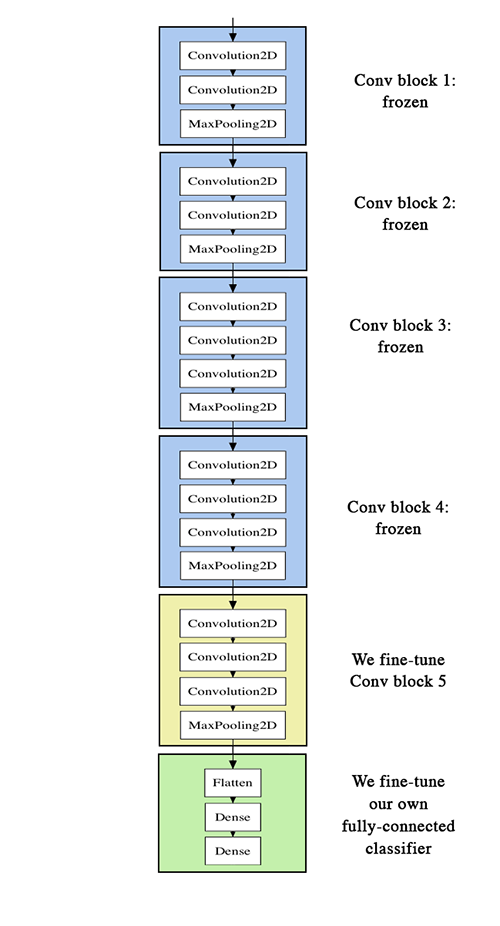

In [22]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense

# path to the model weights files.
weights_path = '../keras/examples/vgg16_weights.h5'
top_model_weights_path = 'fc_model.h5'
# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'cats_and_dogs_small/train'
validation_data_dir = 'cats_and_dogs_small/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16

# build the VGG16 network
model = applications.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model.add(top_model)

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

# fine-tune the model
model.fit_generator(
    train_generator,
    samples_per_epoch=nb_train_samples,
    epochs=epochs,
    validation_data=validation_generator,
    nb_val_samples=nb_validation_samples)


58892288/58889256 [==============================] - 5s     

423413750640/58889256 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Model loaded.


ValueError: The shape of the input to "Flatten" is not fully defined (got (None, None, 512). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

## Multiple GPUs

As a preface to this, I would like to note that your model may not run any faster on multiple GPUs if you are not actually GPU bound; some cases where this can happen include when you use a generator with your data and it‘s creation is CPU/IO bound, or if your model is not particularly complex and you are Memory-bound when transferring data to your GPU. You cna use nvidia-smi or nvidia-settings to check your GPU usage if it lower than 90% you might be bottlenecked by CPU/IO.

https://github.com/fchollet/keras/blob/3dd3e8331677e68e7dec6ed4a1cbf16b7ef19f7f/keras/utils/training_utils.py#L56-L75

Replicates a model on different GPUs.
Specifically, this function implements single-machine
multi-GPU data parallelism. It works in the following way:
- Divide the model's input(s) into multiple sub-batches.
- Apply a model copy on each sub-batch. Every model copy
is executed on a dedicated GPU.
- Concatenate the results (on CPU) into one big batch.
E.g. if your `batch_size` is 64 and you use `gpus=2`,
then we will divide the input into 2 sub-batches of 32 samples,
process each sub-batch on one GPU, then return the full
batch of 64 processed samples.
This induces quasi-linear speedup on up to 8 GPUs.
This function is only available with the TensorFlow backend
for the time being.

In [20]:
from keras.applications import VGG16
from keras.utils.training_utils import multi_gpu_model
from keras.datasets import cifar10

# dimensions of our images.
img_width, img_height = 150, 150

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
nb_train_samples = 2000
nb_validation_samples = 800
epochs = 50
batch_size = 16
# Instantiate the base model
# (here, we do it on CPU, which is optional).
with tf.device('/cpu:0'):
    model = VGG16(weights=None,
                     input_shape=(img_height, img_width, 3),
                     classes=num_classes)
model.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop')
# Replicates the model on 2 GPUs.
# This assumes that your machine has 2 available GPUs.
#parallel_model = multi_gpu_model(model, gpus=1)
#parallel_model.compile(loss='categorical_crossentropy',
#                       optimizer='rmsprop')

# This `fit` call will be distributed on 2 GPUs.
# Since the batch size is 256, each GPU will process 128 samples.
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))

ValueError: Input size must be at least 48x48; got `input_shape=(32, 32, 3)`

## Distributed training
You can trivially make use of TensorFlow distributed training by registering with Keras a TF session linked to a cluster:

In [19]:
server = tf.train.Server.create_local_server()
sess = tf.Session(server.target)

K.set_session(sess)

For more information about using TensorFlow in a distributed setting, see this tutorial https://www.tensorflow.org/deploy/distributed. 

- we choose to only fine-tune the last convolutional block rather than the entire network in order to prevent overfitting, since the entire network would have a very large entropic capacity and thus a strong tendency to overfit. The features learned by low-level convolutional blocks are more general, less abstract than those found higher-up, so it is sensible to keep the first few blocks fixed (more general features) and only fine-tune the last one (more specialized features).
- fine-tuning should be done with a very slow learning rate, and typically with the SGD optimizer rather than an adaptative learning rate optimizer such as RMSProp. This is to make sure that the magnitude of the updates stays very small, so as not to wreck the previously learned features.